# Predicción Precios Argentina - MD 2022

Notebook para la competencias de [Kaggle](https://www.kaggle.com/competitions/fcen-md-2022-prediccion-precio-de-propiedades/leaderboard) de la materia MD de la maestria de DM de la UBA.

Autor: Tomás Delvechio

# Configuración de la notebook

A continuación se definen configuraciones que afectaran el resto del notebook.

In [41]:
import sys
import os.path
from shutil import which


In [52]:
# No tocar
EJECUTA_COLAB = 'google.colab' in sys.modules
ESTA_KAGGLE = not EJECUTA_COLAB \
    and which("kaggle") is not None \
    and os.path.exists(os.path.join(os.getenv("HOME"), ".kaggle/kaggle.json")) 
ENTORNO_DESARROLLO = "Desarrollo"
ENTORNO_PRUEBA = "Prueba"
ENTORNO_PRODUCCION = "Produccion"

## Configuraciones editables

Estas variables pueden ser editadas para cambiar comportamientos del notebook

In [3]:
# Editar para cambiar comportamiento
ENTORNO = ENTORNO_PRUEBA


# Datasets

Se listan todos los datasets a considerar a continuación en un dict

In [4]:
datasets = {

    "input": {

        # Dataset de entrenamiento
        "entrenamiento": {
            "nombre": "properati_ar",
            "archivo": 'ar_properties.csv',
            "archivo_comprimido": "ar_properties.csv.gz",
            "comprimido": "gz",
            "url": "https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz",
        },

        # Dataset de prueba
        "prueba": {
            "nombre": "testing",
            "archivo": "a_predecir.csv",
            "archivo_comprimido": "a_predecir.csv.zip",
            "comprimido": "zip",
            "url": "http://tomasdelvechio.github.io/subjects/dm/a_predecir.csv.zip",
        },

    },

    "output": {

        # Dataset para subir a Kaggle
        "solucion": {
            "nombre": "soluciones",
            "archivo": "solucion.csv",
            "comprimido": False,
            "url": None,
        },

    },

}

## Descarga de los datasets

Controla si los datasets estan o no descargado, en caso de no estarlo, los descarga y descomprime

In [5]:
if EJECUTA_COLAB:
    DOWNLOAD_PATH = '/content'
else:
    DOWNLOAD_PATH = '.data/'
    # tratamos de crear el dir por si es la 1era vez que ejecuta
    ! mkdir -p $DOWNLOAD_PATH

for tipo, ds in datasets["input"].items():
    print(f"Procesando ds para {tipo}: {ds['nombre']}")

    fulllpath = os.path.join(
        DOWNLOAD_PATH, f"{ds['archivo_comprimido']}")
    fulllpath_raw = os.path.join(
        DOWNLOAD_PATH, ds["archivo"])

    if os.path.exists(fulllpath_raw):
        # skip download
        print(f"Dataset {ds['nombre']} descargado... No se descarga...")
    else:
        url = ds["url"]
        print(f"Descargando {ds['nombre']} desde {url}")
        ! wget -N -O $fulllpath -q $url
        if ds["comprimido"] == "gz":
            ! gzip -d -f $fulllpath
        elif ds["comprimido"] == "zip":
            ! unzip -n $fulllpath -d ".data/"
            ! rm $fulllpath

archivo_entrenamiento = os.path.join(
    DOWNLOAD_PATH, datasets["input"]["entrenamiento"]["archivo"])
archivo_prueba = os.path.join(
    DOWNLOAD_PATH, datasets["input"]["prueba"]["archivo"])


Procesando ds para entrenamiento: properati_ar
Dataset properati_ar descargado... No se descarga...
Procesando ds para prueba: testing
Dataset testing descargado... No se descarga...


Preparamos el archivo de salida

In [6]:
archivo_salida = os.path.join(
    DOWNLOAD_PATH, datasets["output"]["solucion"]["archivo"])


## Importación de librerias

In [7]:
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

## Lectura de datos

Se levantan los df de prueba y entrenamiento. No se levantan con el índice `index_col="id"` dado que la [página de properati](https://www.properati.com.ar/data) aclara que podria no ser único.

In [22]:
df_entrenamiento_inicial = pd.read_csv(archivo_entrenamiento)#, index_col="id")
df_prueba_inicial = pd.read_csv(archivo_prueba)#, index_col="id")

if (ENTORNO == ENTORNO_DESARROLLO):
    # filtro para pruebas rápidas
    df_entrenamiento_inicial = df_entrenamiento_inicial.loc[(df_entrenamiento_inicial.l2 == "Córdoba") & (
        df_entrenamiento_inicial.operation_type == 'Venta') & (df_entrenamiento_inicial.property_type == 'Casa')]
    df_entrenamiento_inicial.shape


In [9]:
assert df_entrenamiento_inicial.shape[1] == 25, "El ds de entrenamiento no tiene 25 atributos. Revisar."
assert df_prueba_inicial.shape[1] == 28, "El ds de prueba no tiene 28 atributos. Revisar."


# Análisis del conjunto de datos

Se analizan ambos datasets para conocerlos y caracterizarlos. Primero se hace lo propio con el DF de entrenamiento.

In [10]:
df_entrenamiento_inicial.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,DyVXfkpKygVBKuUk5olH+A==,Propiedad,2020-08-22,2020-09-03,2020-08-22,-34.407468,-58.957367,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,...,NaN,133139.0,NaN,NaN,NaN,Mensual,VENTA - Lote Industrial 130.000m2 - Parque Ind...,Lote (Nro.50) mide 133.139 m2\n<br>Valor: U$S ...,Lote,Venta
1,9naojilaMecJN4jlQiTkGg==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-37.996039,-57.542509,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,...,NaN,687.0,687.0,NaN,NaN,Mensual,Casa - Santa Cecilia,Conjunto edilicio de casa y departamentos en b...,Otro,Venta
2,tlCPRJPjoDEUzuuCelemAQ==,Propiedad,2020-08-22,2020-08-31,2020-08-22,-31.380187,-58.009182,Argentina,Entre Ríos,Concordia,...,1.0,80.0,80.0,NaN,NaN,Mensual,Casa - Concordia,"Casa de un dormitorio, cocina, baño, living co...",Casa,Alquiler
3,Zw3b91glQUO3HNrM5fPYlQ==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-27.494106,-55.123455,Argentina,Misiones,Oberá,...,1.0,NaN,NaN,NaN,NaN,Mensual,Terreno - Obera,IMPORTANTE PROPIEDAD EN VENTA EN OBERA MISIONE...,Lote,Venta
4,bsU81gm9JEgtZCbTYgvykg==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-32.948856,-60.630464,Argentina,Santa Fe,Rosario,...,1.0,76.0,66.0,NaN,NaN,Mensual,Departamento - Rosario,PORTAL DE LOS MARINOS<br>Es un complejo de viv...,Departamento,Venta


Se observan 24 columnas con datos de diversa indole.

Las columnas son:

In [23]:
df_entrenamiento_inicial.dtypes

id                  object
ad_type             object
start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
l4                  object
l5                  object
l6                 float64
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
price_period        object
title               object
description         object
property_type       object
operation_type      object
dtype: object

En principio hay preeminencia de columnas no numéricas.

In [12]:
df_entrenamiento_inicial.dtypes.value_counts()

object     15
float64     9
dtype: int64

In [29]:
df_entrenamiento_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1000000 non-null  object 
 1   ad_type          1000000 non-null  object 
 2   start_date       1000000 non-null  object 
 3   end_date         1000000 non-null  object 
 4   created_on       1000000 non-null  object 
 5   lat              894233 non-null   float64
 6   lon              894191 non-null   float64
 7   l1               1000000 non-null  object 
 8   l2               1000000 non-null  object 
 9   l3               965273 non-null   object 
 10  l4               306162 non-null   object 
 11  l5               5530 non-null     object 
 12  l6               0 non-null        float64
 13  rooms            714179 non-null   float64
 14  bedrooms         649933 non-null   float64
 15  bathrooms        765122 non-null   float64
 16  surface_total    47

Vamos a describir a continuación cada columna. El Id no se lista pero es la columna 25. No es el index del dataframe.

| # | Columna | Descripción |
|---|---------|-------------|
| 1 | ad_type   | Tipo de publicación o aviso |
|---|---------|-------------|
| 2 | start_date    | Fecha de alta |
| 3 | end_date  | Fecha de baja |
| 4 | created_on    | Fecha de alta de la primer versión |
|---|---------|-------------|
| 5 | lat   | Latitud |
| 6 | lon   | Longitud |
| 7 | l1    | País |
| 8 | l2    | Provincia |
| 9 | l3    | Ciudad |
| 10 | l4    | Barrio |
| 11 | l5    | ??? |
| 12 | l6    | ??? |
|---|---------|-------------|
| 13 | rooms | Cantidad de ambientes |
| 14 | bedrooms  | Cantidad de dormitorios |
| 15 | bathrooms | Cantidad de baños |
| 16 | surface_total | Superficie en m² |
| 17 | surface_covered   | Superficie cubierta en m² |
| 18 | price | Precio publicado |
| 19 | currency  | Moneda del precio |
| 20 | price_period  | si el precio es diario, semanal, mensual |
| 21 | title | título del anuncio |
| 22 | description   | descripcion del anuncio |
| 23 | property_type | Si es casa, depto, PH... |
| 24 | operation_type    | Si es venta, alquiler... |

Agrupamos los diferentes conceptos del dataset por columnas relacionadas:

In [93]:
columnas_id = ["id", "ad_type", ]
columnas_fecha = ["start_date", "end_date", "created_on", ]
columnas_ubicacion = [
    "lat",
    "lon",
    "l1",
    "l2",
    "l3",
    "l4",
    "l5",
    "l6",
]
columnas_publicacion = [
    "rooms",
    "bedrooms",
    "bathrooms",
    "surface_total",
    "surface_covered",
    "price",
    "currency",
    "price_period",
    "title",
    "description",
    "property_type",
    "operation_type",
]


## Estudio de columnas de ubicación

A continuación se estudian los valores relacionados a las columnas de ubicación

In [28]:
print(df_entrenamiento_inicial[columnas_ubicacion].head())
df_entrenamiento_inicial[columnas_ubicacion].tail()


         lat        lon         l1                            l2  \
0 -34.407468 -58.957367  Argentina      Bs.As. G.B.A. Zona Norte   
1 -37.996039 -57.542509  Argentina  Buenos Aires Costa Atlántica   
2 -31.380187 -58.009182  Argentina                    Entre Ríos   
3 -27.494106 -55.123455  Argentina                      Misiones   
4 -32.948856 -60.630464  Argentina                      Santa Fe   

              l3   l4   l5  l6  
0          Pilar  NaN  NaN NaN  
1  Mar del Plata  NaN  NaN NaN  
2      Concordia  NaN  NaN NaN  
3          Oberá  NaN  NaN NaN  
4        Rosario  NaN  NaN NaN  


,lat,lon,l1,l2,l3,l4,l5,l6
999995,-32.958863,-60.665633,Argentina,Santa Fe,Rosario,NaN,NaN,NaN
999996,-34.596587,-58.376893,Argentina,Capital Federal,Retiro,NaN,NaN,NaN
999997,-34.576445,-58.432603,Argentina,Capital Federal,Palermo,NaN,NaN,NaN
999998,-32.866636,-68.841144,Argentina,Mendoza,NaN,NaN,NaN,NaN
999999,-34.447524,-58.631552,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Santa Barbara Barrio Cerrado,NaN,NaN


In [35]:
print("Colname - % de nulls")
df_entrenamiento_inicial[columnas_ubicacion].isna(
).sum() / len(df_entrenamiento_inicial)


Colname - % de nulls


lat    0.105767
lon    0.105809
l1     0.000000
l2     0.000000
l3     0.034727
l4     0.693838
l5     0.994470
l6     1.000000
dtype: float64

Al parecer l5 es candidata a desaparecer y l6 será eliminada seguramente.

Miraremos a continuación la distribución de las columnas númericas.

<AxesSubplot:>

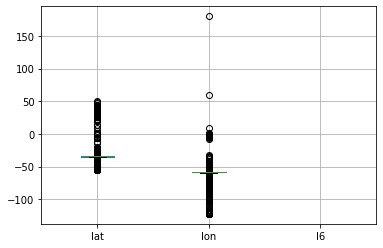

In [38]:
df_entrenamiento_inicial[columnas_ubicacion].boxplot()


## Estudio de columnas de fechas

A continuación se estudian los valores relacionados a las columnas de fechas

In [39]:
df_entrenamiento_inicial[columnas_fecha].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   start_date  1000000 non-null  object
 1   end_date    1000000 non-null  object
 2   created_on  1000000 non-null  object
dtypes: object(3)
memory usage: 22.9+ MB


Son columnas strings, no datetime

In [40]:
df_entrenamiento_inicial[columnas_fecha].head()


,start_date,end_date,created_on
0,2020-08-22,2020-09-03,2020-08-22
1,2020-08-22,2020-09-04,2020-08-22
2,2020-08-22,2020-08-31,2020-08-22
3,2020-08-22,2020-09-04,2020-08-22
4,2020-08-22,2020-09-04,2020-08-22


In [41]:
df_entrenamiento_inicial[columnas_fecha].describe()


,start_date,end_date,created_on
count,1000000,1000000,1000000
unique,362,450,362
top,2020-10-02,9999-12-31,2020-10-02
freq,25159,208960,25159


<AxesSubplot:xlabel='start_date,end_date,created_on'>

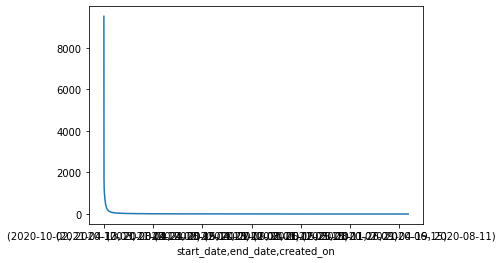

In [51]:
df_entrenamiento_inicial[columnas_fecha].value_counts().plot()
#df_entrenamiento_inicial[columnas_fecha].value_counts()[:5].plot()


Se puede observar que las combinaciones de fechas siguen un patron de "Ley de Potencias".

¿Que pasa con cada columna individual?

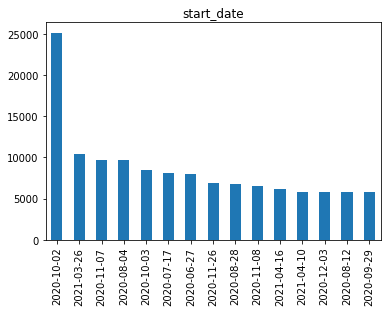

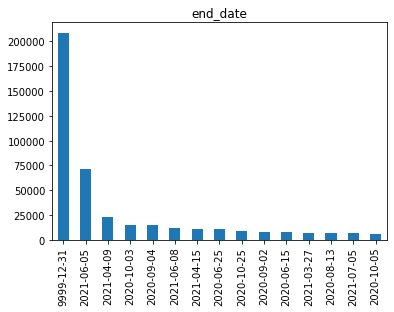

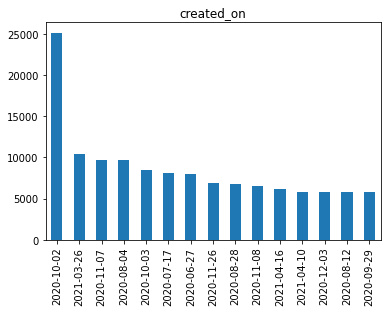

In [69]:
for columna in columnas_fecha:
    df_entrenamiento_inicial[columna].value_counts()[:15].plot(kind='bar')
    plt.title(columna)
    plt.show()


La columna `end_date` se usa bastante mal. El valor con mayor frecuencia es `9999-12-31`. El mismo aparece mas del 20 % de las veces.

Por otro lado, parece que las columnas `start_date` y `created_on` son iguales.

In [73]:
assert (df_entrenamiento_inicial.start_date ==
        df_entrenamiento_inicial.created_on).sum() == len(df_entrenamiento_inicial), \
        "El ds de entrenamiento tiene diferencias entre columnas start_date y created_on"


## Estudio de columnas de publicación

Las columnas de publicación son aquellas que refieren a información de la propiedad publicada.

In [75]:
df_entrenamiento_inicial[columnas_publicacion].describe(include=object)

,currency,price_period,title,description,property_type,operation_type
count,955491,429870,999999,999958,1000000,1000000
unique,5,3,548833,817449,10,3
top,USD,Mensual,casa-venta,Departamento en Alquiler de 1 dorm. en Cordoba,Departamento,Venta
freq,738157,429842,3338,1980,457907,750831


In [76]:
df_entrenamiento_inicial[columnas_publicacion].describe()


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,714179.000000,649933.000000,765122.000000,477831.000000,4.877560e+05,9.582430e+05
mean,2.916567,2.097815,1.708581,513.760752,1.165622e+04,3.460940e+05
std,1.739685,2.079008,1.092221,4297.241604,4.443191e+06,5.713690e+06
min,1.000000,-16.000000,1.000000,-136.000000,-1.300000e+02,0.000000e+00
25%,2.000000,1.000000,1.000000,50.000000,4.500000e+01,3.800000e+04
50%,3.000000,2.000000,1.000000,95.000000,7.800000e+01,9.700000e+04
75%,4.000000,3.000000,2.000000,250.000000,1.680000e+02,2.100000e+05
max,40.000000,900.000000,20.000000,200000.000000,2.147484e+09,3.100000e+09


In [102]:
columnas_publicacion_sin_precio = list(columnas_publicacion)
columnas_publicacion_sin_precio.remove('price')


<AxesSubplot:>

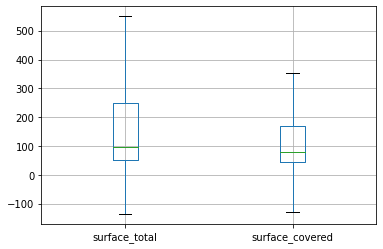

In [117]:
df_entrenamiento_inicial[['surface_total', 'surface_covered']].boxplot(
    showfliers=False)


<AxesSubplot:>

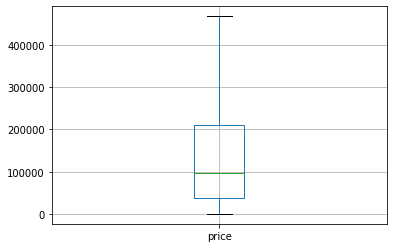

In [112]:
df_entrenamiento_inicial[['price']].boxplot(
    showfliers=False)


En cuanto a los NaNs presentes en estas columnas, se puede observar lo siguiente:

In [118]:
print("Colname - % de nulls")
df_entrenamiento_inicial[columnas_publicacion].isna(
).sum() / len(df_entrenamiento_inicial)


Colname - % de nulls


rooms              0.285821
bedrooms           0.350067
bathrooms          0.234878
surface_total      0.522169
surface_covered    0.512244
price              0.041757
currency           0.044509
price_period       0.570130
title              0.000001
description        0.000042
property_type      0.000000
operation_type     0.000000
dtype: float64

Se observan varios casos donde la cantidad de NaNs es mas de la mitad de las columnas

# Tratamiento de los datos

**TODO**
* Determinar método para eliminar columnas con mas de un X % de NaNs.
* Pasar cols de fechas a datetimes
* Eliminar col created_on pues es igual a start_date

In [25]:
df_entrenamiento_inicial.columns


Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

In [26]:
df_prueba.shape

(1087, 25)

# Modelización

In [30]:
df_entrenamiento_inicial = df_entrenamiento_inicial.select_dtypes(include=['float64', 'int64'])
df_entrenamiento_inicial.fillna(0, inplace=True, downcast= "infer")

df_prueba = df_prueba_inicial[df_entrenamiento_inicial.columns].copy()


In [ ]:
X = df_entrenamiento_inicial[df_entrenamiento_inicial.columns.drop('price')]
y = df_entrenamiento_inicial['price']

for n_estimators in [100, 500, 1000]:
    for max_depth in [3, 7, 11]:

        ## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

        ## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
        scores = sk.model_selection.cross_val_score(reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

        ## Imprimimos scores. Cuando más bajo mejor
        print(f"n_estimators={n_estimators}, max_depth={max_depth} --> {-scores.mean():.3f} +/- {scores.std():.3f}")


In [31]:
X = df_entrenamiento_inicial[df_entrenamiento_inicial.columns.drop('price')]
y = df_entrenamiento_inicial['price']


In [ ]:
# version todo por 2 pesos
## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
reg = sk.ensemble.RandomForestRegressor(
    n_estimators=100, max_depth=7, random_state=42, n_jobs=-1)

## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
scores = sk.model_selection.cross_val_score(
    reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

## Imprimimos scores. Cuando más bajo mejor
print(f"{-scores.mean():.3f} +/- {scores.std():.3f}")


In [32]:
#df_pred = pd.read_csv(archivo_prueba, index_col="id")
df_prueba.fillna(0, inplace=True)

In [33]:
X_pred = df_prueba[X.columns]


In [34]:
# los mejores hiperparámetros encontrados antes
n_estimators = 100
max_depth = 7

# entrenamiento
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
reg.fit(X, y)

# predicción
df_prueba["price"] = reg.predict(X_pred)


In [65]:
# grabo la solución
df_prueba.index.name = 'id'
df_prueba["id"] = df_prueba_inicial.id
df_prueba[["id", "price"]].to_csv(archivo_salida, index=False)


In [66]:
if ESTA_KAGGLE:
    ! kaggle competitions submit -c fcen-md-2022-prediccion-precio-de-propiedades -f $archivo_salida -m "Prueba enviar predicción desde Notebook"


100%|██████████████████████████████████████| 23.1k/23.1k [00:02<00:00, 11.1kB/s]
Successfully submitted to FCEN MD 2022 - Predicción precio de propiedades